# ASSIGNMENT 5

**Name:** Orhun  
**Surname:** Görkem  
**Id:** 2017400171  

**Note: I used Google Colab for jax implementation. When it is rerun on Jupyter Notebook, there may be some indentation errors. However, my outputs are ready without running in my submission.**


## Question 1

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import jax
import jax.numpy as jnp

In [3]:
data = pd.read_csv("iris.data")
data = data.loc[49:]

In [4]:
y = data.iloc[:,-1:].to_numpy()
A = data.iloc[:,0:4].to_numpy()

In [5]:
for i in range(100):
    if i<50:
        y[i]=0
    else:
        y[i]=1

### a)

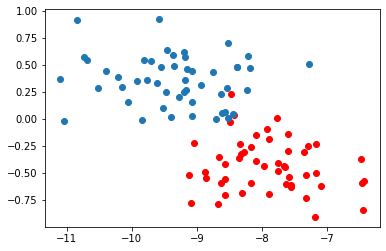

In [6]:
u,s,v = np.linalg.svd(A)
sigma = np.zeros(A.shape)
for i in range(len(s)):
    sigma[i,i]=s[i]

C = u@sigma
X = C[:,0:2]

a = X[:,0:1]
b = X[:,1:2]
plt.scatter(a[:50],b[:50],color = 'r')
plt.scatter(a[50:],b[50:])

### b)

$$ A = U.\Sigma.V^T $$

As discovered in last assignment, the weights multiplied with $V^T$ become smaller as we proceed along the diagonal of $\Sigma$. Therefore, we had said that, the first column of $V$ was the most representative column for $A$ and it brings approximations a summary property. Here we have,

$$ C = U.\Sigma = A.V  $$

since $V$ is orthonormal.
Calling first two columns of $C$ as $X$, $X$ consists of the multiplication of $A$ with the first 2 columns of $V$.  

This is why we can assert that $X$ is a sufficient candidiate to represent $A$ in our analysis.  
 
At first, we had 100 vectors in 4-dimensional space. By the approximation above, we projected our data to a plane, so obtained 100 vectors on a 2-dimensional space. This 2-D space can be represented with first 2 columns of $U$ since $C$ matrix consists of scaled versions of the columns of $U$. As $U$ being orthonormal, we do not need to prove that those 2 columns form a basis.  

We could derive infinitely many planes from the initial 4-D space. However, the one with the basis having first 2 columns of U is the most representative one in sense of seperating the data. 


## Question 2


$$ y \approx \hat{y} = \sigma(\beta + \theta^T.x) $$

$$ \sigma(a) = \frac{1}{1+e^{-a}}$$

Note that we will ignore $\beta$ here for simplicity.

$$L(\theta)= \frac{1}{N}. \sum_{1}^{N} -y_i.\log{\hat{(y_i)}} - (1 - y_i).\log{(1-\hat{y_i}})  $$

We will use gradient descent to optimize log loss for logistic regression. Let $\theta ^{(k)}$ be the paramteres in $k$. iteration.


$$ \theta^{(k+1)} = \theta^{(k)} - \eta. \sum_{1}^{N} \nabla_{\theta^{(k)}}L(\theta^{(k)})   $$


### a)


$$  \nabla_{{\theta_1}^{(k)}}L(\theta^{(k)})= \sum_{i = 1}^{N} \frac{\partial L}{\partial \hat{y}_i }.\frac{\partial \hat{y}_i }{\partial \theta_1 }  $$

$$ \frac{\partial L}{\partial \hat{y}_i } = \frac{-1}{N}.(\frac{y_i}{\hat{y}_i} - \frac{1-y_i}{1-\hat{y}_i})   $$

$$ \frac{\partial \hat{y}_i }{\partial \theta_1 } =  \sigma(\theta^T.x).(1-\sigma(\theta^T.x)).x_{i,1}
$$
(where $x_{i,1}$ represents first element of first observation)

Then if we replace $\hat{y}_i$ with $\sigma(\beta+ \theta^T.x_i)$, we can get the gradient in terms of $X$, $y$ and $\theta$ after applying the multiplication and sum formula.This can be applied for any $\theta_i$.

In the following code, we can implement this.


In [9]:
np.random.seed(0)
theta_init = np.random.randn(2,1)/10

def sigmoid(a):
  return 1/(1+jnp.exp(-1*a))


def model(theta, x):
  return sigmoid(theta.T@x)

def dLdy(y_hat, y ,N):
  return (-1/N)*(y/y_hat - (1-y)/(1-y_hat))

def dydt(x,theta,index):
  s = model(theta,x)
  return s*(1-s)*x[index-1]

sum1 = 0
sum2 = 0
for i in range(len(X)):
  x = X[i]
  yi = y[i][0]
  y_hat_i = model(theta_init,x)[0]
  a=dLdy(y_hat_i,yi,100)
  b1=dydt(x,theta_init,1)
  b2=dydt(x,theta_init,2)
  sum1+= a*b1  #for theta 1
  sum2+= a*b2  #for theta 1

print("Gradients:",sum1[0],sum2[0])



Gradients: 3.1345506 -0.19211866


So the gradient values are above. I calculated it according to initial $\theta$. We can verify the result with the following code:

In [10]:
def model2(theta, X):   # model is actually same but here instead of loops, I multiply the whole matrix
  return sigmoid(X@theta)

def L(theta,x,y):
  y_hat = model2(theta, x)
  y = y.astype('float32')
  y_hat = y_hat.astype('float32')
  
  sum = jnp.sum(-1*y*jnp.log(y_hat)-(1-y)*jnp.log(1-y_hat))
  return sum/len(x)

np.random.seed(0)
theta_init = np.random.randn(2,1)/10

dL = jax.value_and_grad(L)

dL(theta_init,X,y)

(DeviceArray(1.015273, dtype=float32), DeviceArray([[ 3.1345503 ],
              [-0.19211864]], dtype=float32))

As seen, the gradient values hold to some precision.

### b)

In [11]:
def gradientDescent(K, eta, theta, X, y):

  for i in range(K):
    obj = dL(theta,X,y)
    loss = obj[0]
    dTheta = obj[1]
    theta -= eta*dTheta
  
  return theta


In [12]:
theta_optimal = gradientDescent(10000,0.05,theta_init,X,y)

In [13]:
print("Optimal parameters: "+str(theta_optimal[0])+" "+str(theta_optimal[1]))

Optimal parameters: [-0.04136017] [10.1252575]


### c)

In [14]:
def predict(theta,X):

  pred_y = sigmoid(X@theta)
  pred_y = np.array(pred_y)
  for i in range(len(pred_y)):
    if pred_y[i,0]>0.5:
      pred_y[i,0] = 1
    else:
      pred_y[i,0] = 0

  return pred_y


pred_y = predict(theta_optimal,X)

def accuracy(pred_y,y):
  count = 0
  for i,j in zip(pred_y, y):
    if i==j:
      count+=1

  return count/100

print("Accuracy", accuracy(pred_y,y))


Accuracy 0.96


### d)

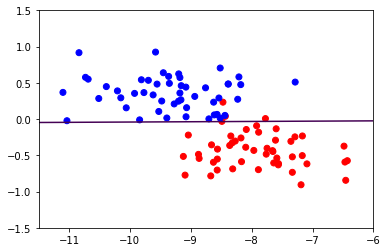

In [25]:

no_pts = 100
x_1 = np.linspace(-11.5, -6, no_pts)
x_2 = np.linspace(-1.5, 1.5, no_pts)
x_1_grid, x_2_grid = np.meshgrid(x_1, x_2)
p_grid = sigmoid(x_1_grid*theta_optimal[0]+x_2_grid*theta_optimal[1])
p_grid = np.array(p_grid)


colors = []
for i in range(100):
  if i<50:
    colors.append('r')
  else:
    colors.append('b')

fig, ax = plt.subplots()
ax.scatter(X[:,0:1],X[:,1:2],color=colors)
ax.contour(x_1_grid, x_2_grid, p_grid, levels=[.5]);

## Question 3

### a)

The model is an artificial neural network with one hidden layer. 

$$ f_0 = x_i $$
$$ f_1 = \sigma(W_1.f_0) =\sigma(z_1) $$
$$ f_2 = \sigma(w_2^T.f_1) = \hat{y_i} =\sigma(z_2) $$

Call the logloss function $L$.
$$ \frac{\partial L}{\partial w_2} =\frac{1}{N}. \sum_{i=1}^{N} \frac{\partial L}{\partial \hat{y_i}}. \frac{\partial \hat{y_i}}{\partial w_2}
= \frac{1}{N}. \sum_{i=1}^{N} \frac{\partial L}{\partial \hat{y_i}}. \frac{\partial \hat{y_i}}{\partial z_2} .\frac{\partial z_2}{\partial w_2}$$

$$ \frac{\partial L}{\partial W_1} =\frac{1}{N}. \sum_{i=1}^{N} \frac{\partial L}{\partial \hat{y_i}}. \frac{\partial \hat{y_i}}{\partial f_1}.
\frac{\partial f_1}{\partial W_1} $$

for jth index of $w_2$:

$$\frac{\partial L}{\partial {w_2}_i} =\frac{1}{N}. \sum_{i=1}^{N} \frac{\partial L}{\partial \hat{y_i}}. \frac{\partial \hat{y_i}}{\partial {w_2}_i}
= \frac{1}{N}. \sum_{i=1}^{N} \frac{\partial L}{\partial \hat{y_i}}. \frac{\partial \hat{y_i}}{\partial z_2} .\frac{\partial z_2}{\partial {w_2}_i}
$$

$$
= \frac{1}{N}. \sum_{i=1}^{N} \frac{\partial L}{\partial \hat{y_i}}.\sigma(z_2).(1-\sigma(z_2)).f_{1j}
$$

In the following code, I implemented the gradient for $w_2$ manually.



In [17]:
np.random.seed(0)
W_1_init = np.random.randn(5, 2)/10
w_2_init = np.random.randn(5)/10

def dLdw2(X,y,W1,w2,index):

  
  gradients=[]

  for j in range(5):
    sum = 0
    for i in range(len(X)):
      x = X[i]
      yi = y[i][0]
      y_hat_i = sigmoid(w2.T@sigmoid(W1@x))
      a=dLdy(y_hat_i,yi,100)
      z2 = w2.T@sigmoid(W1@x)
      f1 = sigmoid(W1@x)
      b = sigmoid(z2)*(1-sigmoid(z2))*f1[index-1]
      sum += a*b  #for theta 
    index+=1
    gradients.append(sum)

  return gradients

dLdw2(X,y,W_1_init,w_2_init,1)




[DeviceArray(0.01186303, dtype=float32),
 DeviceArray(0.00444533, dtype=float32),
 DeviceArray(0.01549518, dtype=float32),
 DeviceArray(0.01434932, dtype=float32),
 DeviceArray(0.00827241, dtype=float32)]

In the following code, I got the gradient with JAX.

In [18]:
def nn_model(W1, w2, x):
  return sigmoid((sigmoid(W1@x.T)).T@w2)

def L2(parameters,X,y):

  W1=parameters[0]
  w2=parameters[1]
  
  y_hat = nn_model(W1,w2,X)
  
  y = y.astype('float32')
  y_hat = y_hat.astype('float32')
  y_hat = jnp.expand_dims(y_hat,axis=1)
  sum = jnp.sum(-1*y*jnp.log(y_hat)-(1-y)*jnp.log(1-y_hat))
  return sum/len(X)


dL2 = jax.value_and_grad(L2)

dL2([W_1_init,w_2_init],X,y)

(DeviceArray(0.6947611, dtype=float32),
 [DeviceArray([[-0.00027884, -0.00042362],
               [ 0.00609088, -0.00600699],
               [-0.00333379, -0.00213887],
               [ 0.0001179 , -0.00051192],
               [ 0.00183163, -0.00218804]], dtype=float32),
  DeviceArray([0.01186304, 0.00444532, 0.01549519, 0.01434932, 0.00827242],            dtype=float32)])

If checked, we can see that the reusults hold with jax built in gradient function. 

### b)


$$ y \approx \hat{y} = \sigma({w_2}^T.(\sigma(W_1.x))$$

In [19]:
def gradientDescent2(K, eta, parameters, X, y):
  W1=parameters[0]
  w2=parameters[1]
  loss = 0
  for i in range(K):
    
    obj = dL2(parameters,X,y)
    loss = obj[0]
    dW1 = obj[1][0]
    dw2 = obj[1][1]
    parameters[0] -= eta*dW1
    parameters[1] -= eta*dw2
  
  return parameters,loss

In [20]:
parameters,loss = gradientDescent2(10000,0.05,[W_1_init,w_2_init],X,y)

print("Optimal parameters: ",parameters)
print("Loss: ",loss)

Optimal parameters:  [DeviceArray([[ 0.07696449, -2.5675242 ],
             [-0.08570719,  4.9797125 ],
             [ 0.07757735, -3.468717  ],
             [ 0.07776392, -3.5265408 ],
             [-0.09593927,  0.7358318 ]], dtype=float32), DeviceArray([-3.1289344 ,  5.4881005 , -4.1036425 , -4.1744328 ,
              0.87454337], dtype=float32)]
Loss:  0.10645004


### c)


In [21]:
W1 = parameters[0]
w2 = parameters[1]

In [22]:
def predict2(W1,w2,X):

  pred_y = nn_model(W1,w2,X)
  pred_y = np.array(pred_y)

  for i in range(len(pred_y)):
    if pred_y[i]>0.5:
      pred_y[i] = 1
    else:
      pred_y[i] = 0

  return pred_y


In [23]:
pred = predict2(W1,w2,X)
accuracy(pred,y)

0.97

### d)

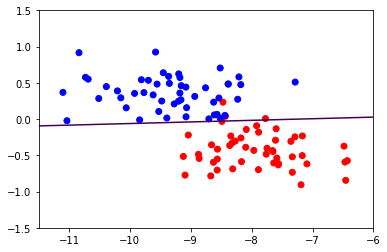

In [24]:
no_pts = 100
x_1 = np.linspace(-11.5, -6, no_pts)
x_2 = np.linspace(-1.5, 1.5, no_pts)
x_1_grid, x_2_grid = np.meshgrid(x_1, x_2)
p_grid = np.zeros((no_pts,no_pts))
for i in range(no_pts):
  for j in range(no_pts):
    x_1 = x_1_grid[i, j]
    x_2 = x_2_grid[i, j]
    x =np.array([[x_1],[x_2]])
    p_grid[i,j] = sigmoid(w2@(sigmoid(W1@x)))


colors = []
for i in range(100):
  if i<50:
    colors.append('r')
  else:
    colors.append('b')

fig, ax = plt.subplots()
ax.scatter(X[:,0:1],X[:,1:2],color=colors)
ax.contour(x_1_grid, x_2_grid, p_grid, levels=[.5]);

We see that for this case, both logistic regression and multilayer perceptron approaches brought success. MLP approach took more time since it has more computational procedures. While LR had 0.96 accuracy, MLP had 0.97 accuracy. This little improvement do not seem to be convincing against approximately 2 minutes of efficiency difference.  

Decision boundaries also look similar. MLP has a slightly higher slope which yielded the improvement we sav in accuracies.    

We could expect a nonlinear decision boundary from MLP since we introduce non linearity using the sigmoid function to a 2 step calculation where hidden layer nodes are also results of sigmoid. However, a linear boundary even handles the seperation of types with a low loss in our case. Maybe we could capture a few more observations correctly with adding a slight non-linearity to a piece if we had increased the number $K$, or number of layers, or changed the activation function. Note that single layer perceptron can not bring nonlinearty to the boundary.  

On the other hand, we could not expect such a nonlinearity from logistic regression since there are only 2 decision parameters which will map the data points in a linear fashion.

## Question 4

### a)

$K$ is the number of iterations to update parameters and $\eta$ is the learning rate.   
* $\eta$ should be carefully determined since Gradient Descent is an algorithm that iterates with feedbacks and we would want that the evaluation of feedbacks be meaningful. If $\eta$ is very large, we can not move precisely in our vector space and may move apart from the aimed local minimum with diverging effect of high learning rate. On the other hand, with a very low learning rate, the model would hardly adjust itself and yielding a proper accuracy would take too long. Therefore, picking $\eta$ has a tradeoff.  

* $K$ is more straightforward. If we increase $K$, the model increases more with more feedback, but the time efficiency drops. $K$ should be picked to be sufficiently accurate but also time efficient.  

If we have possiblity to increase $K$, decreasing $\eta$ may be useful to some extent. If we do not want to take it long, one can try a low $K$ with a higher $\eta$ and trace the losses. If losses keep on decreasing, this would also work.

Note that these arguments are to increase the performance of training set. As if think of test sets, we would seek for a generalized performance, not a model to memorize what we have in the training set. Therefore, increasing $K$ will always increase the performance over training set but may cause **overfitting**.  

In short, we can begin with a small $K$ with high $\eta$ and trace the losses. If losses seem to decrease coonsistently, there is not problem with $\eta$. Else, I would decrease $\eta$ and try again until there is no problem. Then if model works fast and performance is insufficient, we can increase $K$ until there is a sign of overfitting and time efficiency drops too much. 

### b)

As I stated, we could expect a nonlinear and flexible boundary from MLP whereas LR is not eligible for that. However, in case of generalization, do we think that the whole data has a distribution with complex nonlinear patterns? No, see that blue points are generally in upper left part while red points are in bottom right. When the nature of the data is linear, introducing nonlinearity to the decision boundary may be useless and cause overfitting. Therefore, logistic regression is expected to have a better performance in sense of generalization. Adding that with proper parameters, we could build a successful generalized model with MLP too. 

### c)

$p$ is the number of activation nodes in the hidden layer. $p$ directly determines the capacity of the system to keep imformation about the training set since increasing $p$ will bring more weights and adjustments will be more flexible.  

As expected, if $p$ is too low, flexibility and capacity drops and one can encounter **underfitting**.   

If $p$ is too high, most of the information in the training set will be stored in the weights of the neural networks, this will bring **overfitting**.  

For generalization, $p$ should be adjusted to keep the essence of the data, and not to keep outliers.I read that having $p$ between the number of input nodes and output nodes is a rule of thumb. In our case, this may seem to be ridiculous, however in our case probably using MLP is also unnecessary since our dataset is linearly seperable. 